## Importando dependências

In [1]:
# pip install tensorflow sklearn

In [3]:
import numpy as np
import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.losses import Loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [7]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])
    dataset.iloc[:, -1] = y
    
def normalize_two_dataset_labels(dataset1, dataset2):
    y1 = dataset1.iloc[:, -1].values
    y2 = dataset2.iloc[:, -1].values
    y = np.concatenate((y1, y2))
    unique_labels = sorted(list(set(y)))
    for i in range(len(y1)):
        y1[i] = unique_labels.index(y1[i])
    for i in range(len(y2)):
        y2[i] = unique_labels.index(y2[i])
    dataset1.iloc[:, -1] = y1
    dataset2.iloc[:, -1] = y2
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    
def keep_threat_data(dataset):
    return dataset.loc[dataset['class'] != 0]

def remove_minority_data(dataset):
    label_counts = dataset['class'].value_counts()
    minority_labels = list()
    for label, count in label_counts.items():
        if count <= 5:
            minority_labels.append(label)
            
    final_dataset = dataset.copy()
    for label in minority_labels:
        final_dataset = final_dataset.loc[dataset['class'] != label]
        
    return final_dataset
        

def apply_mixed_oversample(X, y):
    unique_values = set(y)
    value_counts = {}
    for val in unique_values:
        value_counts[val] = list(y).count(val)
    smote_classes, random_classes, k = ({}, {}, sys.maxsize)
    max_count = max(value_counts.values())

    for key, value in value_counts.items():
        if value > 5:
            smote_classes[key] = max_count
            if k > value:
                k = value - 1
        else:
            random_classes[key] = max_count

    smote_oversample = SMOTE(sampling_strategy = smote_classes, k_neighbors = k)
    random_oversample = RandomOverSampler(sampling_strategy = random_classes)
    X, y = smote_oversample.fit_resample(X, y)
    return random_oversample.fit_resample(X, y)
    
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24.csv', names=HEADER)
initial_dataset_02_25 = pd.read_csv('dataset-oi-2017-02-25.csv', names=HEADER)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26.csv', names=HEADER)

test_dataset = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
central_dataset = initial_dataset_02_25.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()

# initial_dataset = initial_dataset_02_24.append(initial_dataset_02_26, ignore_index=True)

central_dataset = keep_threat_data(central_dataset)
central_dataset = remove_minority_data(central_dataset)

binarize_dataset_labels(initial_dataset)
normalize_two_dataset_labels(central_dataset, test_dataset)

## Criando modelo NN global

In [8]:
class Net:
    def build(self, shape = (41,), classes = 141):
        model = Sequential()
        model.add(Dense(200, input_shape=shape))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))            
        
        self.built = model
        
        return model

    def compile(self, learning_rate = 0.01, comms_round = 100):
        self.built.compile(loss = 'sparse_categorical_crossentropy', 
                           optimizer = SGD(learning_rate=learning_rate, decay=learning_rate / comms_round, momentum=0.9),
                           metrics = ['accuracy'])

## Criando modelo do cliente

In [9]:
class Client:
    def __init__(self, client_id = 123, dataset = [1.0, 2.0]):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_tree = DecisionTreeClassifier(random_state=0, max_depth=35, criterion='entropy')
        self.metrics = list()
        self.local_forest = [self.local_tree]
        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values
        
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

#         X, y = apply_mixed_oversample(X, y)
                
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True)
        
    def train_tree(self):
        # depth 35 é o melhor aplicando grid seach
        self.local_tree.fit(self.X_train, self.y_train)
        
    def test_tree(self):
        y_pred = self.local_tree.predict(self.X_test)
        
        precision = Precision()
        precision.update_state(self.y_test, y_pred)
        prec = precision.result().numpy()
        
        recall = Recall()
        recall.update_state(self.y_test, y_pred)
        rec = recall.result().numpy()
        
        acc = self.local_tree.score(self.X_test, self.y_test)
        
        self.metrics = [acc, prec, rec]
        print(f"[INFO] Accuracy of client {self.client_id} tree = {acc}")
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)  

## Criando modelo de servidor central

In [29]:
class Server:
    def __init__(self, dataset = list(), model = Net()):
        self.central_dataset = dataset
        self.central_model = model
        
    def build_labels_oversampling(self):
        label_counts = self.central_dataset['class'].value_counts()
        target_sample = label_counts.values[1]
        labels_dict = {}
        for label, count in label_counts.items():
            if count <= target_sample:
                labels_dict[label] = target_sample
                
        return labels_dict
        
    def preprocess(self):
        print("[INFO] Preprocessing central dataset")
        X = self.central_dataset.iloc[:, 5:-1].values
        y = self.central_dataset.iloc[:, -1].values
        
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
         
        labels_dict = self.build_labels_oversampling()
        smote_oversample = SMOTE(sampling_strategy=labels_dict)
        X, y = smote_oversample.fit_resample(X, y)

        self.num_labels = max(self.central_dataset['class'].value_counts().keys()) + 1
        self.input_shape = X.shape[1:]
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
        
    def train_model(self):
        print("[INFO] Training central model")
        self.central_model.build(classes = self.num_labels, shape = self.input_shape)
        self.central_model.compile()
        self.central_model.built.fit(self.X_train, 
                                   self.y_train, 
                                   batch_size = 64, 
                                   epochs=10, 
                                   verbose=0)
        print()
        
    def test_model(self):
        print("[INFO] Testing central model")
        y_pred = self.central_model.built.predict(self.X_test).argmax(axis=1)
        
        self.precision = precision_score(self.y_test, y_pred, average = 'micro')
        self.recall = recall_score(self.y_test, y_pred, average = 'micro')
        
        self.loss, self.accuracy = self.central_model.built.evaluate(self.X_test, self.y_test)
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm) 

## Splitando dataset para os clientes da rede

In [11]:
num_clients = 20
max_num_trees = 10
clients = [Client(client_id = i) for i in range(num_clients)]

# pega os N primeiros clientes com mais dados e que possuem dataset com > 1 classe
unique_ips = initial_dataset['srcip'].value_counts().head(num_clients + 10).keys()
client_index, srcip = (0,0)
while client_index < num_clients:
    local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip]]
    num_classes = len(local_dataset['class'].value_counts())
    if num_classes > 1:
        print(f"[DEBUG] values counts for client {client_index} = {local_dataset['class'].value_counts()}")
        clients[client_index].local_dataset = local_dataset
        client_index += 1 
    srcip += 1
        

[DEBUG] values counts for client 0 = 0.0    184151
1.0     75087
Name: class, dtype: int64
[DEBUG] values counts for client 1 = 0.0    207006
1.0     26837
Name: class, dtype: int64
[DEBUG] values counts for client 2 = 0.0    135555
1.0        18
Name: class, dtype: int64
[DEBUG] values counts for client 3 = 1.0    59235
0.0    44384
Name: class, dtype: int64
[DEBUG] values counts for client 4 = 0.0    69581
1.0     8601
Name: class, dtype: int64
[DEBUG] values counts for client 5 = 0.0    59569
1.0     6689
Name: class, dtype: int64
[DEBUG] values counts for client 6 = 0.0    62884
1.0       15
Name: class, dtype: int64
[DEBUG] values counts for client 7 = 1.0    27116
0.0    26281
Name: class, dtype: int64
[DEBUG] values counts for client 8 = 1.0    26947
0.0    24079
Name: class, dtype: int64
[DEBUG] values counts for client 9 = 0.0    36905
1.0    14041
Name: class, dtype: int64
[DEBUG] values counts for client 10 = 0.0    45109
1.0       14
Name: class, dtype: int64
[DEBUG] values

## Treinando e testando modelos DT locais

In [12]:
for client in clients:
    client.preprocess()
    client.train_tree()
    client.test_tree()

print("[INFO] All local trains are finished!")

[INFO] Accuracy of client 0 tree = 0.8318353649128221
[[34183  2643]
 [ 6076  8946]]
[INFO] Accuracy of client 1 tree = 0.9293549145801706
[[40261  1103]
 [ 2201  3204]]
[INFO] Accuracy of client 2 tree = 0.9998893601327679
[[27112     0]
 [    3     0]]
[INFO] Accuracy of client 3 tree = 0.8664833043813935
[[ 7352  1583]
 [ 1184 10605]]
[INFO] Accuracy of client 4 tree = 0.9169917503357421
[[13813    93]
 [ 1205   526]]
[INFO] Accuracy of client 5 tree = 0.9964533655297314
[[11900    29]
 [   18  1305]]
[INFO] Accuracy of client 6 tree = 0.9996025437201908
[[12575     2]
 [    3     0]]
[INFO] Accuracy of client 7 tree = 0.8487827715355806
[[4343  892]
 [ 723 4722]]
[INFO] Accuracy of client 8 tree = 0.8404859886341368
[[3913  939]
 [ 689 4665]]
[INFO] Accuracy of client 9 tree = 0.8750736015701668
[[7044  342]
 [ 931 1873]]
[INFO] Accuracy of client 10 tree = 0.9995567867036012
[[9020    1]
 [   3    1]]
[INFO] Accuracy of client 11 tree = 0.7702949919963412
[[4765  879]
 [1130 1972]

## Compartilhando DTs e atualizando FedForest

In [13]:
import random
for current in range(num_clients):
    clients[current].local_forest = [clients[current].local_tree]
    appended_trees, replaced_trees, acc_list = (0,0,[])
    for neighbour in range(num_clients):
        if current != neighbour:
            neighbour_tree = clients[neighbour].local_tree
            acc = neighbour_tree.score(clients[current].X_test, clients[current].y_test)
            
            if len(clients[current].local_forest) <= max_num_trees:
                clients[current].local_forest.append(neighbour_tree)
                acc_list.append(acc)
                appended_trees += 1
            else:
                min_acc = min(acc_list)
                min_index = acc_list.index(min_acc) # seleciona a árvore de menor acurácia
#                 min_index = random.randint(0,max_num_trees-1) # seleciona uma árvore aleatória
                if min_acc < acc:
                    clients[current].local_forest[min_index] = neighbour_tree # substitui a árvore pela nova
                    acc_list[min_index] = acc
                    replaced_trees += 1
    print(f"Client {current} appended {appended_trees} and replaced {replaced_trees} trees to forest with max accuracy = {max(acc_list)}")
                

Client 0 appended 10 and replaced 5 trees to forest with max accuracy = 0.7775420459805585
Client 1 appended 10 and replaced 8 trees to forest with max accuracy = 0.8843464688148133
Client 2 appended 10 and replaced 8 trees to forest with max accuracy = 0.9998893601327679
Client 3 appended 10 and replaced 3 trees to forest with max accuracy = 0.820546226597182
Client 4 appended 10 and replaced 7 trees to forest with max accuracy = 0.8892370659333632
Client 5 appended 10 and replaced 8 trees to forest with max accuracy = 0.8997887111379415
Client 6 appended 10 and replaced 8 trees to forest with max accuracy = 0.9997615262321145
Client 7 appended 10 and replaced 3 trees to forest with max accuracy = 0.8206928838951311
Client 8 appended 10 and replaced 4 trees to forest with max accuracy = 0.836174799137762
Client 9 appended 10 and replaced 5 trees to forest with max accuracy = 0.8013738959764475
Client 10 appended 10 and replaced 7 trees to forest with max accuracy = 0.9995567867036012


## Testando a RF dos clientes

In [14]:
import statistics
from statistics import mode

def forest_predict(forest, X):
    forest_prediction = list()
    for row in X:
        tree_predictions = list()
        for tree in forest:
            tree_predictions.append(tree.predict([row])[0])
        forest_prediction.append(mode(tree_predictions))
    return forest_prediction

for client in clients:
    accuracy = Accuracy()
    forest_pred = forest_predict(client.local_forest, client.X_test)
    accuracy.update_state(client.y_test, forest_pred)
    acc = accuracy.result().numpy()
    client.local_forest_acc = acc
    
    print(f"[INFO] Accuracy of client {client.client_id} forest = {acc}")

[INFO] Accuracy of client 0 forest = 0.7614565491676331
[INFO] Accuracy of client 1 forest = 0.8844320178031921
[INFO] Accuracy of client 2 forest = 0.9998893737792969
[INFO] Accuracy of client 3 forest = 0.5719938278198242
[INFO] Accuracy of client 4 forest = 0.8893010020256042
[INFO] Accuracy of client 5 forest = 0.9001660346984863
[INFO] Accuracy of client 6 forest = 0.9997615218162537
[INFO] Accuracy of client 7 forest = 0.604681670665741
[INFO] Accuracy of client 8 forest = 0.6634332537651062
[INFO] Accuracy of client 9 forest = 0.8018645644187927
[INFO] Accuracy of client 10 forest = 0.9995567798614502
[INFO] Accuracy of client 11 forest = 0.7596615552902222
[INFO] Accuracy of client 12 forest = 0.9046822786331177
[INFO] Accuracy of client 13 forest = 0.9986587762832642
[INFO] Accuracy of client 14 forest = 0.9979522228240967
[INFO] Accuracy of client 15 forest = 0.6380622982978821
[INFO] Accuracy of client 16 forest = 0.9974527955055237
[INFO] Accuracy of client 17 forest = 0.99

## Plotando resultados dos treinos locais

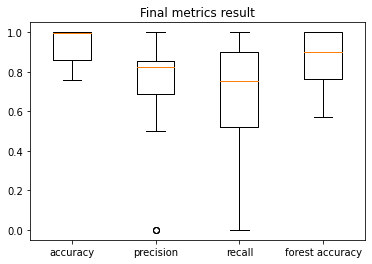

In [15]:
final_metrics = [[],[],[],[]]
for client in clients:
    for i in range(3):
        final_metrics[i].append(client.metrics[i])
    final_metrics[3].append(client.local_forest_acc)

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1, 2, 3, 4], ['accuracy', 'precision', 'recall', 'forest accuracy'])
plt.show()

## Treinando modelo central

In [ ]:
server = Server(dataset=central_dataset)

server.preprocess()
server.train_model()
server.test_model()

[INFO] Preprocessing central dataset
1      1560298
4        80817
5        60884
13       20538
47       18531
        ...   
143          6
195          6
104          6
193          6
188          6
Name: class, Length: 134, dtype: int64
80817
{4: 80817, 5: 80817, 13: 80817, 47: 80817, 30: 80817, 8: 80817, 9: 80817, 21: 80817, 18: 80817, 78: 80817, 6: 80817, 103: 80817, 10: 80817, 24: 80817, 138: 80817, 186: 80817, 83: 80817, 191: 80817, 25: 80817, 23: 80817, 77: 80817, 31: 80817, 64: 80817, 22: 80817, 94: 80817, 190: 80817, 49: 80817, 43: 80817, 56: 80817, 63: 80817, 12: 80817, 44: 80817, 91: 80817, 41: 80817, 151: 80817, 157: 80817, 129: 80817, 84: 80817, 50: 80817, 207: 80817, 210: 80817, 192: 80817, 177: 80817, 7: 80817, 2: 80817, 60: 80817, 29: 80817, 42: 80817, 3: 80817, 99: 80817, 213: 80817, 179: 80817, 52: 80817, 109: 80817, 144: 80817, 149: 80817, 54: 80817, 164: 80817, 34: 80817, 19: 80817, 118: 80817, 178: 80817, 88: 80817, 196: 80817, 120: 80817, 102: 80817, 48: 80817, 

## Simulando fluxo de detecção de ataque

In [17]:
class bcolor:
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'

for client in clients:
    client_ip = client.local_dataset['srcip'].value_counts().keys()[0]
    client_test_dataset = test_dataset.loc[test_dataset['srcip'] == client_ip]
    threat_data = client_test_dataset.loc[client_test_dataset['class'] > 0].head(20)
    no_threat_data = client_test_dataset.loc[client_test_dataset['class'] == 0].head(20)
    
    client_test_dataset = threat_data.append(no_threat_data)
    client_test_dataset = client_test_dataset.sample(frac=1).reset_index(drop=True)
    
    X = client_test_dataset.iloc[:, 5:-1].values
    y = client_test_dataset.iloc[:, -1].values
    
    if len(y) < 1:
        continue
    
    binarizer = Binarizer()
    y_binarized = binarizer.fit_transform([y])[0]
    
    print(f"\nClient {client.client_id} simulation starting!")
    client_correctly_pred, client_miss_pred, server_correctly_pred, server_miss_pred = (0,0,0,0)
    for row, binary_label, label in zip(X, y_binarized, y):
        print(f"[DEBUG] Row with label {label}")
        prediction = forest_predict(client.local_forest,[row])[0]
        if prediction == binary_label:
            client_correctly_pred += 1
            if prediction == 1:
                print(f"{bcolor.WARNING}[INFO] Threat detected by client |0.0| ! Sending data to server ...{bcolor.ENDC}")
                row =  np.array([row], dtype=np.float64)
                threat_type = server.central_model.built.predict(row).argmax(axis=1)[0]
                if threat_type == label:
                    server_correctly_pred += 1
                    print(f"{bcolor.OKGREEN}[INFO] Threat type {threat_type} correctly predicted B) !{bcolor.ENDC}")
                else: 
                    server_miss_pred += 1
                    print(f"{bcolor.FAIL}[INFO] Threat type {threat_type} miss predicted :/ !{bcolor.ENDC}")
            else:
                print(f"{bcolor.OKGREEN}[INFO] No threat detected :D !{bcolor.ENDC}")
        else:
            client_miss_pred += 1
            print(f"{bcolor.FAIL}[INFO] Oh no ... client miss predicted the {binary_label} label :/ !{bcolor.ENDC}")
            
    print(f"[INFO] Client miss predicted {client_miss_pred} and correctly predicted {client_correctly_pred} ({(client_correctly_pred/(client_correctly_pred+client_miss_pred))*100}% correct)")
    if server_correctly_pred != 0 or server_miss_pred != 0:
        print(f"[INFO] Server miss predicted {server_miss_pred} and correctly predicted {server_correctly_pred} ({(server_correctly_pred/(server_correctly_pred+server_miss_pred))*100}% correct)")    


Client 0 simulation starting!
[DEBUG] Row with label 0
[INFO] Oh no ... client miss predicted the 0 label :/ !
[DEBUG] Row with label 1
[INFO] Oh no ... client miss predicted the 1 label :/ !
[DEBUG] Row with label 1
[INFO] Threat detected by client |0.0| ! Sending data to server ...
[INFO] Threat type 0 miss predicted :/ !
[DEBUG] Row with label 0
[INFO] No threat detected :D !
[DEBUG] Row with label 0
[INFO] No threat detected :D !
[DEBUG] Row with label 0
[INFO] No threat detected :D !
[DEBUG] Row with label 0
[INFO] No threat detected :D !
[DEBUG] Row with label 0
[INFO] No threat detected :D !
[DEBUG] Row with label 1
[INFO] Oh no ... client miss predicted the 1 label :/ !
[DEBUG] Row with label 0
[INFO] No threat detected :D !
[DEBUG] Row with label 1
[INFO] Threat detected by client |0.0| ! Sending data to server ...
[INFO] Threat type 0 miss predicted :/ !
[DEBUG] Row with label 1
[INFO] Oh no ... client miss predicted the 1 label :/ !
[DEBUG] Row with label 1
[INFO] Threat de